# Data exploration

### Setup

In [ ]:
!pip install -r requirements.txt

### Getting data from s3

In [2]:
import pandas as pd
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt

In [3]:
bucket_name = 'ds-benedict-tmp'
file_name = 'ds_interview_data.csv'
file_path = f's3://{bucket_name}/{file_name}'

df = wr.s3.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21960 entries, 0 to 21959
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   postcode                 21960 non-null  object 
 1   bedrooms                 21960 non-null  int64  
 2   main_type                21960 non-null  object 
 3   second_level_type        21938 non-null  object 
 4   footprint_area_sqm       21951 non-null  float64
 5   abshmin                  21943 non-null  float64
 6   absh2                    21941 non-null  float64
 7   abshmax                  21943 non-null  float64
 8   relh2                    21941 non-null  float64
 9   relhmax                  21943 non-null  float64
 10  internal_floor_area_sqm  21806 non-null  float64
 11  chain_1_hash             17152 non-null  object 
dtypes: float64(7), int64(1), object(4)
memory usage: 2.0+ MB


### Ideas for investigation
- [x] Check for Null values
    - There are quite a few missing values in **chain_1_hash** (we can keep it along until observing its informativeness else we can drop this column. 
    - For other columns nan values are low proportion of total so we can potentially just drop nan rows from these columns for simplicity
- [x] Check for correlated features and drop some of them
- [x] Check feature information (considering classification task)
- [x] Target variable analysis (considering classification task), verify correct stratification
- [ ] Start with low penalisation on parametric models as they may naturally underfit on this sufficiently large dataset
- [ ] Check for feature importance 
- [ ] Try RFECV (Poisson regression)
- [ ] Try Boosting and check feature importance. Compare with previous results

In [4]:
target = 'bedrooms'
features = df.columns.difference([target])

df_non_na = df.dropna(subset=features.difference(['chain_1_hash'])) # Drop na values using all feature columns except chain_1_hash
X,y = df_non_na[features], df_non_na[target]

### Checking correlation between features (using numeric features only)

We can identify collinearity between features and drop some of them to avoid instabilities in the models later on

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


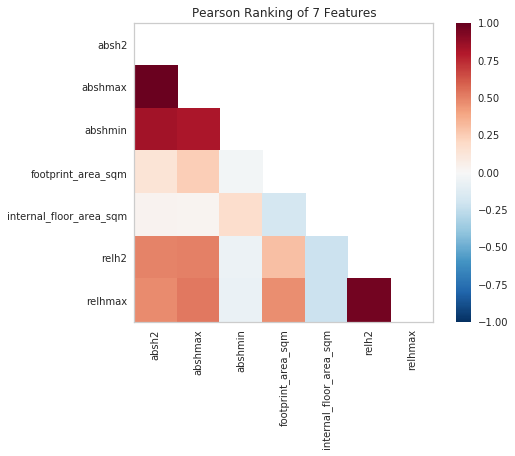

,absh2,abshmax,abshmin,footprint_area_sqm,internal_floor_area_sqm,relh2,relhmax
0,29.7,30.7,18.1,95.26830,81.0,11.6,12.6
1,25.1,28.8,18.2,67.70440,165.0,6.9,10.6
2,25.3,29.0,18.4,84.70275,184.0,6.9,10.6
3,24.2,28.7,18.5,89.63606,218.0,5.7,10.2
4,25.3,28.8,18.7,71.91312,172.0,6.6,10.1
...,...,...,...,...,...,...,...
21955,16.4,18.1,9.5,81.66702,68.0,6.9,8.6
21956,18.5,22.0,13.6,85.30910,66.0,4.9,8.4
21957,28.9,31.0,19.0,68.82183,60.0,9.9,12.0
21958,28.4,31.7,22.4,86.00033,64.0,6.0,9.3


In [5]:
from yellowbrick.features import Rank2D

X_numeric_ = X.select_dtypes(np.double)
visualizer = Rank2D(algorithm='pearson')
visualizer.fit_transform_show(X_numeric_)


- It makes sense that relh2 and relhmax are correlated and so are absh2 and abshmax. For these variables we can potentially just take one and drop the other 
- To a significant degree abshmin happens to be correlated with absh2 and abshmax. We can explore this in slight more detail before making a decision

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


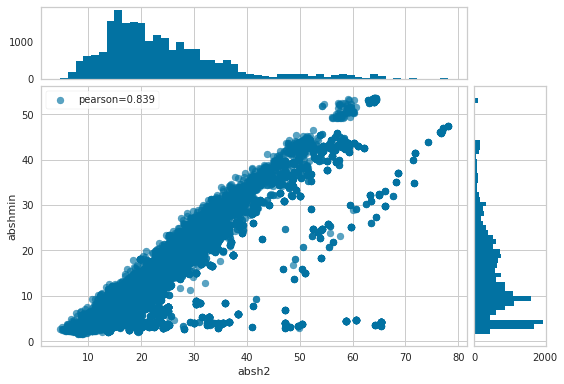

,absh2,abshmax,abshmin,footprint_area_sqm,internal_floor_area_sqm,relh2,relhmax
0,29.7,30.7,18.1,95.26830,81.0,11.6,12.6
1,25.1,28.8,18.2,67.70440,165.0,6.9,10.6
2,25.3,29.0,18.4,84.70275,184.0,6.9,10.6
3,24.2,28.7,18.5,89.63606,218.0,5.7,10.2
4,25.3,28.8,18.7,71.91312,172.0,6.6,10.1
...,...,...,...,...,...,...,...
21955,16.4,18.1,9.5,81.66702,68.0,6.9,8.6
21956,18.5,22.0,13.6,85.30910,66.0,4.9,8.4
21957,28.9,31.0,19.0,68.82183,60.0,9.9,12.0
21958,28.4,31.7,22.4,86.00033,64.0,6.0,9.3


In [6]:
from yellowbrick.features import JointPlotVisualizer

columns = ['absh2', 'abshmin']
visualizer = JointPlotVisualizer(columns=columns)
visualizer.fit_transform_show(X_numeric_,y)


Looking at the plot it appears that `abshmin` encodes slightly more information than absh2 being bimodal so we can keep this and **drop absh2 and abshmax**. We will also keep `relhmax` and these both should approximately capture the effect of elevation and build height

In [7]:
numeric_columns_to_drop = ['relh2', 'absh2', 'abshmax']
numeric_features = X_numeric_.columns.difference(numeric_columns_to_drop)


### Checking informativeness in features

In [8]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

X,y = df.dropna()[features], df.dropna()[target]

high_cardinality_features = ['chain_1_hash', 'postcode']
categorical_features = [f for f in df.select_dtypes(['object']).columns if (f not in high_cardinality_features)]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder()

column_transformer = ColumnTransformer([('numeric_data', 'passthrough', numeric_features), 
                                       ('categorical_data', one_hot_encoder, categorical_features),
                                       ('high_cardinality_features', ordinal_encoder, high_cardinality_features)])

Xt = column_transformer.fit_transform(X)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


FeatureCorrelation(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f2620128590>,
                   labels=['abshmin', 'footprint_area_sqm',
                           'internal_floor_area_sqm', 'relhmax', 'x0_FLA',
                           'x0_HSE', 'x1_BLK', 'x1_CNV', 'x1_DET', 'x1_SEM',
                           'x1_TERR', 'chain_1_hash', 'postcode'],
                   method='mutual_info-classification')

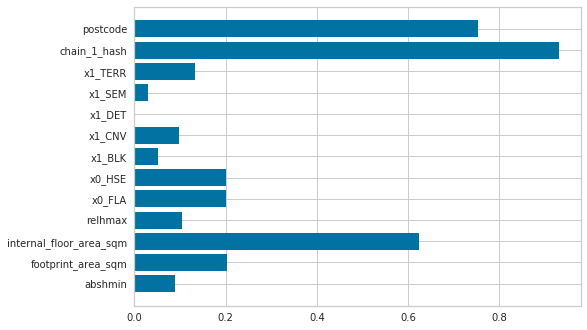

In [9]:
from yellowbrick.target import FeatureCorrelation

feature_names = list(numeric_features) + list(column_transformer.named_transformers_['categorical_data'].get_feature_names()) + high_cardinality_features
discrete = [False]*len(numeric_features) + [True]*(Xt.shape[1] - len(numeric_features))
visualizer = FeatureCorrelation(method='mutual_info-classification', labels=feature_names)
visualizer.fit(Xt, y, discrete_features=discrete, random_state=0)

Earlier it was suggested that we may drop `chain_1_hash` because it has many NaN values which can't realistically be imputed. 
However, this column has much information about target variable and instead of losing all that information we prefer to model houses that do not have this information separately (or working with models that can incorporate missing values natively).
This is also important because dropping *NaN* value rows on the basis of `chain_1_hash` removes data about **Detached** houses entirely (blank row on chart).

### Target analysis

Ideally for the nature of target variable (counts) we would approach the problem as some version of **Poisson regression**.
However, it is important to not have an error of even single bedroom in our predictions means we can frame the problem as a classification problem and try to achieve high accuracy on the classification task.

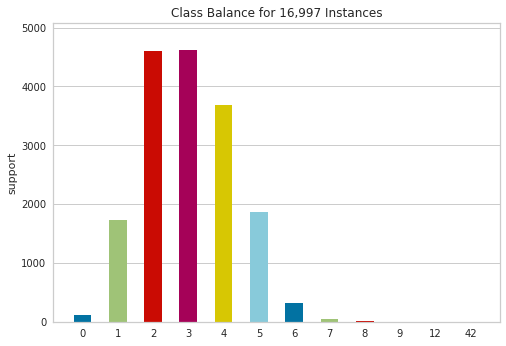

Unique values in target: 
 3     4619
2     4605
4     3676
5     1860
1     1738
6      321
0      120
7       48
8        7
12       1
9        1
42       1
Name: bedrooms, dtype: int64


In [10]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance()
visualizer.fit(y).show()
print('Unique values in target: \n', y.value_counts(sort=True))

Because of the distribution of classes being non-uniform a proper train-test split should be used (Stratified for simplicity)

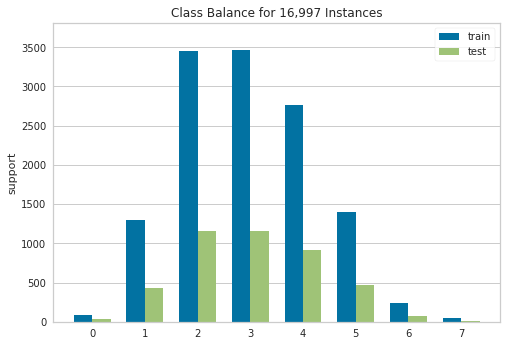

In [11]:
from sklearn.model_selection import train_test_split

yt = y.copy()
yt.loc[y>6] = 7 # Need to label all the classes with single instances to some common value to allow stratified splits
X_train, X_test, y_train, y_test = train_test_split(Xt, yt,
                                                    stratify=yt, 
                                                    test_size=0.25)
    
visualizer = ClassBalance()
visualizer.fit(y_train, y_test).show()

We appear to have a sensible split of training and test data and can progress to modelling from here.

### Modelling

We can start with a simple model which we can consider as baseline and then build more complex models successively improving the scores

**Assumptions**
- We don't wan't to focus of any particular class we can just assume `accuracy` as a good metric to optimise
- Because the dataset has large number of instances and quite a few features, it is likely that parametric models may underfit the data. Hence we'll start with minimal regularisation
- We will first build a suitable model with `chain_1_hash` included and then move on to model instances that have `chain_1_hash` value missing. If needed we can then merge 2 models into 1 composite model

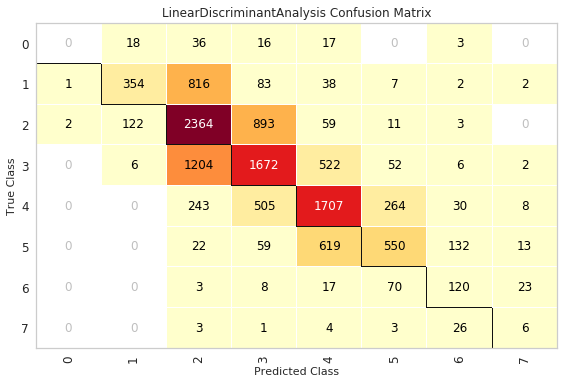

Model accuracy: 0.5374117647058824


In [16]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model = LinearDiscriminantAnalysis()

pipe = Pipeline([('Scaler', StandardScaler()), ('model', model)])

visualizer = ConfusionMatrix(pipe, support=True)

visualizer.fit(X_train, y_train)     
visualizer.score(X_train, y_train)
visualizer.show()

print("Model accuracy:", accuracy_score(y_test, pipe.predict(X_test)))

We can consider this our base model and without spending much time improving it because of its obvious limitations, we can move on to other more complex models and try to improve on the base accuracy score

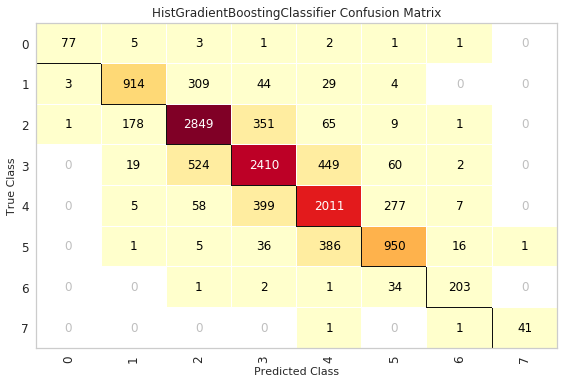

Model accuracy: 0.6494117647058824


In [18]:
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier

model = HistGradientBoostingClassifier()

pipe = Pipeline([('Scaler', StandardScaler()), ('model', model)])

visualizer = ConfusionMatrix(pipe, support=True)

visualizer.fit(X_train, y_train)     
visualizer.score(X_train, y_train)
visualizer.show()

print("Model accuracy:", accuracy_score(y_test, pipe.predict(X_test)))